In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.4.0
False


# Import Libraries

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper
from PIL import *
import cv2

# Loading Image Data

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transforms)
```

where `'path/to/data'` is the file path to the data directory and `transforms` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/alien/xxx.png
root/alien/xxy.png
root/alien/xxz.png

root/predator/123.png
root/predator/nsdf3.png
root/predator/asd932_.png
```

where each class has it's own directory (`alien` and `predator`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `predator`. It is also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `data/train` folder, define a few transforms, then build the dataloader.

In [0]:
!unzip alien-vs-predator-images.zip
!ls

In [0]:
data_dir = 'data/train'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [0]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.


In [0]:
data_dir = 'data/'

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(256),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(299),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

torch.Size([32, 3, 256, 256])
torch.Size([32, 196608])


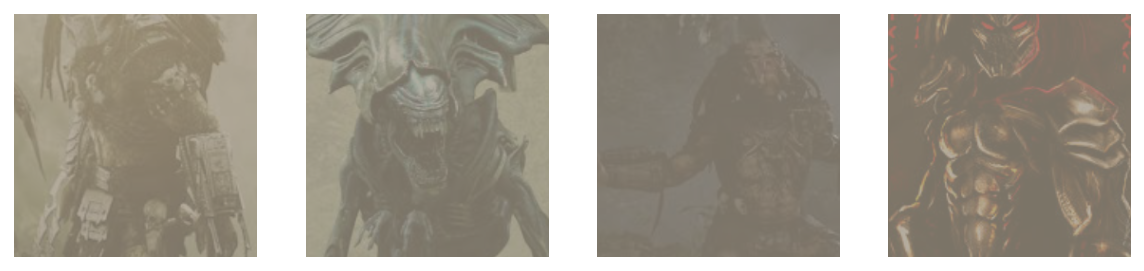

In [18]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
print(images.shape)
print(images.view(images.shape[0], -1).shape)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax)

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify aliens vs predators. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. Note that these images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

# A better method
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Specify your network layers
        # e.g. self.fc1 = nn.Linear(input, hidden)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout

        # output so no dropout here
        
        #return
        return x

In [20]:
## Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003) # Adam is a better performer than SGD because it has momentum to avoid local minima problem
epochs = 30
steps = 0
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Forward pass, then backward pass, then update weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # Adds the current loss to runing_loss variable
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval() # set to evaluation mode
            
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model.forward(images)
                test_loss += criterion(log_ps, labels)
                
                ps = F.softmax(log_ps, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        model.train() # set to train mode

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
      

Epoch: 1/30..  Training Loss: 38.212..  Test Loss: 0.695..  Test Accuracy: 0.496
Epoch: 2/30..  Training Loss: 0.763..  Test Loss: 0.682..  Test Accuracy: 0.647
Epoch: 3/30..  Training Loss: 0.705..  Test Loss: 0.685..  Test Accuracy: 0.496
Epoch: 4/30..  Training Loss: 0.705..  Test Loss: 0.687..  Test Accuracy: 0.496
Epoch: 5/30..  Training Loss: 0.693..  Test Loss: 0.693..  Test Accuracy: 0.500
Epoch: 6/30..  Training Loss: 0.678..  Test Loss: 0.659..  Test Accuracy: 0.607
Epoch: 7/30..  Training Loss: 0.692..  Test Loss: 0.669..  Test Accuracy: 0.598
Epoch: 8/30..  Training Loss: 0.683..  Test Loss: 0.686..  Test Accuracy: 0.549
Epoch: 9/30..  Training Loss: 0.679..  Test Loss: 0.627..  Test Accuracy: 0.612
Epoch: 10/30..  Training Loss: 0.719..  Test Loss: 0.681..  Test Accuracy: 0.509
Epoch: 11/30..  Training Loss: 0.695..  Test Loss: 0.688..  Test Accuracy: 0.536
Epoch: 12/30..  Training Loss: 0.696..  Test Loss: 0.687..  Test Accuracy: 0.594
Epoch: 13/30..  Training Loss: 0.689

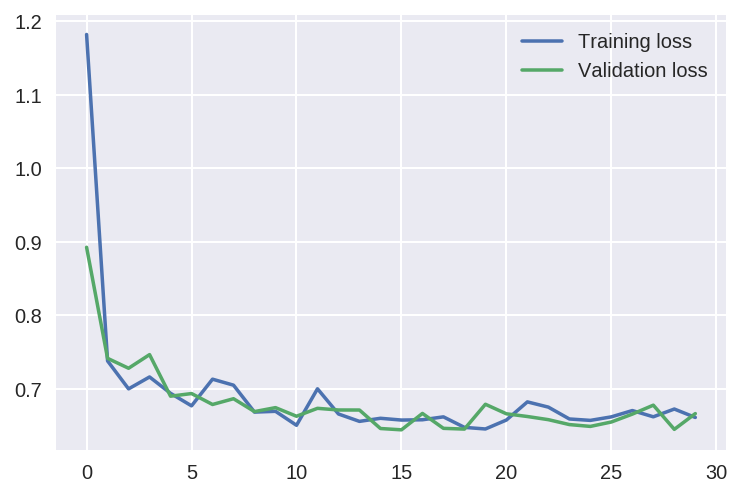

In [0]:
# Model Complexity Graph
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Validation loss')
plt.legend(frameon = False)

# Inference

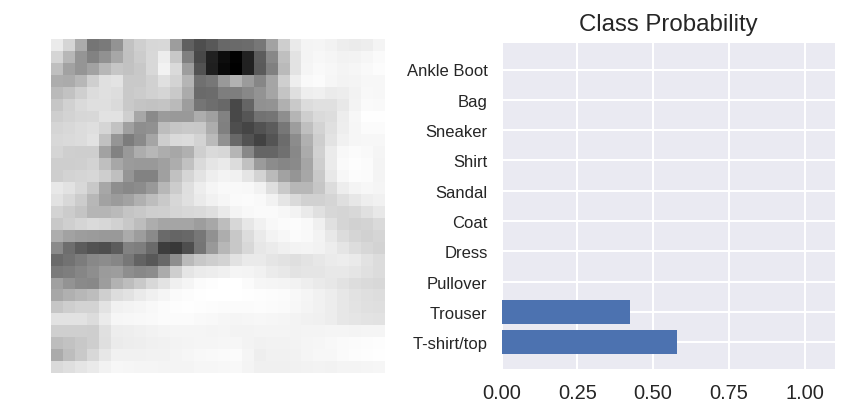

In [0]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, -1)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, -1), ps, version='Fashion')